In [1]:
# imports
import numpy as np
from getting_analytical_data import *
from numba import njit,jit,prange
import matplotlib.pyplot as plt
import sys
from scipy.sparse import csr_matrix,csc_matrix
import scipy as sp
import time
from tqdm import tqdm

In [2]:
# read in data
N,times,rs_linspace,thetas_linspace,rs,thetas,Z_anal = get_anal_data()
_,_,_,_,_,_,Z_anal_long = get_anal_data_long()

dt_anal = times[1]
dr_anal = rs_linspace[1]
dtheta_anal = thetas_linspace[1]
X = rs * np.cos(thetas)
Y = rs * np.sin(thetas)

# Z_num = np.load("Z_iterative.npy")

100%|██████████| 3/3 [00:00<00:00,  5.59it/s]


In [3]:
# functions

# takes NxN matrix, returns 1xN^2 flattened matrix. u[i,j] --> u[i+Nj=k]
# @jit(forceobj=True)
@njit
def flatten(matrix):
#     return matrix.reshape(-1)
    size = len(matrix)
    line = np.zeros((size**2))
    count = 0
    for i in list(range(size)):
        for j in list(range(size)):
            line[count] = matrix[i,j]
            count += 1
    return line

@jit(forceobj=True)
def unflatten(line):
#     size = int(np.sqrt(np.size(line)))
    size = int(np.sqrt(len(line)))
    return line.reshape(size,size)

# bad
@njit
def get_A(dt,dr,dtheta):
    A = np.zeros((N**2,N**2))
    
    ctr2 = (dt / dr)**2
    ctrt2 = (dt / (dr*dtheta))**2
    
    for k in list(range(N**2)):
        j = k % N 
        i = int(np.floor(k / N))
        
        # coeffs for u[i,j]
        A[k,k] = 2 + ctr2 - 2*ctrt2/((i+1)**2)

        # coeffs for u[i+1,j]
        if k < N**2-1:
            A[k,k+1] = (2+1/(i+1))*ctr2 ### !!!!!!!!!!!!!!

        # u[i+2,j]
        if k < N**2-2:
            A[k,k+2] = (1+1/(i+1))*ctr2            

        # u[i,j-1]
        A[k,k-N] = ctrt2/((i+1)**2)
        
        # u[i,j+1]
        if j != N-1:
            A[k,k+N] = ctrt2/((i+1)**2)
            
        # if i==N-2, set u[i+2,j] = u[i+1,j], instead of 0 like you've been doing
        if i == N-2:
            A[k,(k+N)%N**2] = -ctr2
            
    return A

@njit
def set_BC(matrix,time):
    new_mat = matrix
    for i in list(range(len(thetas_linspace))):
        theta = thetas_linspace[i]
        new_mat[N-1,i] = np.cos(time) * np.cos(theta)
        
    return new_mat

@njit
def remove_BC(matrix):
    new_mat = matrix
    new_mat[N-1,:] = None
        
    return new_mat

@njit(parallel=True)
def discrete_get_unp1(un, unm1, dt, dr, dtheta, time):
    unp1 = np.zeros((N,N))
    for i in prange(N):
        for j in prange(N):
            # set nearby u values
            uij = un[i,j]
            uip1j = un[(i+1)%N,j]
            uim1j = un[i-1,j]
            uijp1 = un[i,(j+1)%N]
            uijm1 = un[i, j-1]
            
            # set ri and halfs, if r=0 set u=0
            ri = rs_linspace[i]
            if ri == 0:
                unp1[i,j] = 0
                continue
            
            if i == 0:
                rim12 = ri
                rip12 = 0.5 * (ri + rs_linspace[i+1])
            elif i == N-1:
                rip12 == ri
                rim12 = 0.5 * (ri + rs_linspace[i-1])
            else:
                rip12 = 0.5 * (ri + rs_linspace[i+1])
                rim12 = 0.5 * (ri + rs_linspace[i-1])
                
            A = rip12 * ((uip1j - uij) / dr**2)
            B = rim12 * ((uij - uim1j) / dr**2)
            C = (uijp1 - 2*uij + uijm1) / dtheta**2
            RHS = (A - B)/ri + C/ri**2
            
            unp1[i,j] = RHS*dt**2 + 2*uij - unm1[i,j]
                
    unp1 = set_BC(unp1,time)
    return unp1, un

# returns matrix A such that A * u_flat = RHS = LHS
@njit(parallel=True)
def get_A_RHS(dt,dr,dtheta):
    A = np.zeros((N**2, N**2))
    
    for k in list(range(N**2)):
        j = k % N 
        i = int(np.floor(k / N))
        
        ri = rs_linspace[i]

        # if r==0, set u=0
        if ri == 0:
            A[k,k] = 1 # avoid singularity
            continue

        # hald ris
        if i == 0:
            rim12 = ri
            rip12 = 0.5 * (ri + rs_linspace[i+1])
        elif i == N-1:
            rip12 == ri
            rim12 = 0.5 * (ri + rs_linspace[i-1])
        else:
            rip12 = 0.5 * (ri + rs_linspace[i+1])
            rim12 = 0.5 * (ri + rs_linspace[i-1])
            
        # coeffs for u[i,j]
        A[k,k] = (-rip12/dr**2 - rim12/dr**2)/ri - 2/(ri*dtheta)**2 
        
        # u[i+1,j]
        if i != N-1:
            A[k,k+1] = 1/ri * rip12 / dr**2
            
        # u[i-1,j]
        if i != 0:
            A[k,k-1] = 1/ri * rim12 / dr**2
            
        # u[i,j-1]
        A[k,k-N] = 1/ (ri*dtheta)**2
        
        # u[i,j+1]
        A[k,(k+N)%N] = 1/ (ri*dtheta)**2
    return A

def get_errors(Z_DNS_dt,timess):
    L2 = np.array(None)
    max_e = np.array(None)
    MSE = np.array(None)
    shape = np.shape(Z_DNS_dt)
    return_times=np.array(None)
    for i in list(range(shape[2])):
        if round(timess[i],2) != timess[i]:
            continue
        else:
            return_times = np.append(return_times, timess[i])
            Z_DNSi = Z_DNS_dt[:,:,i]
            Z_anali = Z_anal[:,:,int(timess[i]*100)]
        L2i = np.sqrt(np.sum((Z_DNSi-Z_anali)**2))
        L2 = np.append(L2,L2i)
        max_e = np.append(max_e, np.max(np.abs(Z_DNSi-Z_anali)))
        MSE = np.append(MSE, np.sum((Z_DNSi-Z_anali)**2) / N**2)
        
    return L2, max_e, MSE, return_times

# getting numerical solution DISCRETE NEXT STEP method
def discrete_run(dt, max_time, record_all=False):
    Z0 = Z_anal[:,:,0]
    
    total_time = dt
    timess = 0

    Z1,Z0 = discrete_get_unp1(Z0,Z0, dt, dr_anal, dtheta_anal, total_time)

    Z_DNS = Z0


    Z_last = Z0
    Z = Z1
    
    total_timesteps = int(max_time / dt)
    for i in tqdm(range(total_timesteps)):
        total_time = round(dt + total_time,9)

        Znp1,Z = discrete_get_unp1(Z,Z_last, dt, dr_anal, dtheta_anal, total_time)

        Z_last = Z
        Z = Znp1

        if round(total_time,2) == total_time and not record_all:
            Z_DNS = np.dstack((Z_DNS,Z))
            timess = np.append(timess, total_time)
        elif record_all:
            Z_DNS = np.dstack((Z_DNS,Z))
            timess = np.append(timess, total_time)
            
    return Z_DNS,timess

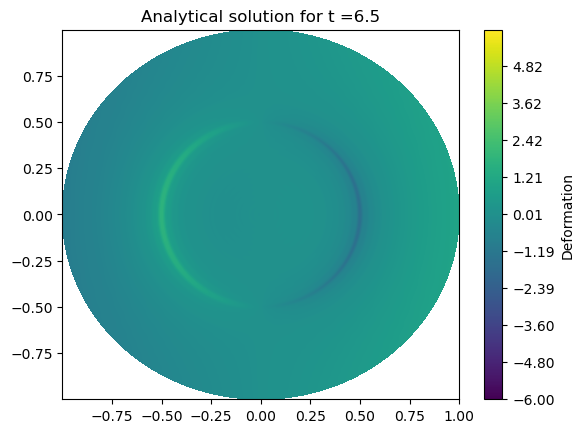

In [4]:
# plotting analytical solution

tstep = 650
Z_anali = Z_anal[:,:,tstep]

levels = np.linspace(-6,6,500)
# levels = np.linspace(np.min(Z_anali),np.max(Z_anali),200)

plt.figure()

plot = plt.contourf(X, Y, Z_anali, levels=levels, cmap='viridis')
# plot = plt.imshow(Z_anali)

colorbar = plt.colorbar(plot)
colorbar.set_label('Deformation')
plt.title("Analytical solution for t ="+ str(tstep/100));

In [5]:
max_time = 2

Z_DNS_div,times_div = discrete_run(1.6e-4, .05,record_all=True)
Z_DNS_CFL,times_CFL = discrete_run(1.5e-4, .05,record_all=True)
Z_DNS_1en4,times_1en4 = discrete_run(1e-4, max_time)
Z_DNS_1en5,times_1en5 = discrete_run(1e-5, max_time)
# Z_DNS_1en6,times_1en6 = discrete_run(1e-6, max_time)
# Z_DNS_1en4_long = discrete_run(1e-4, 100)


100%|██████████| 199999/199999 [00:31<00:00, 6399.16it/s]


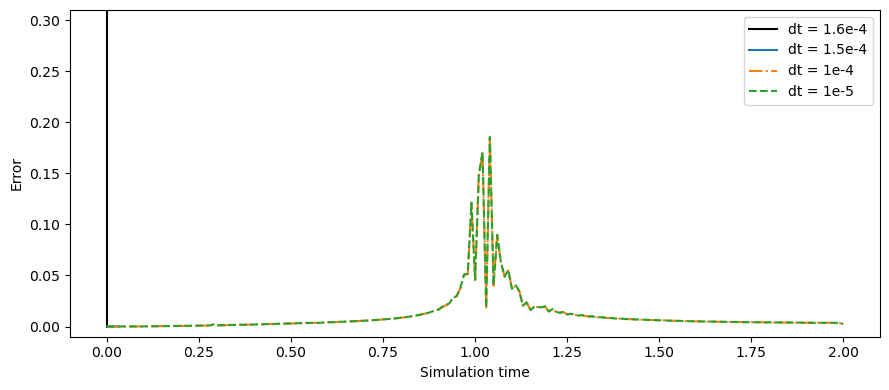

In [13]:
# comparison of MSEs at different delta ts
fig = plt.figure()
fig.set_figheight(4)
fig.set_figwidth(9)

# times_here = times[:max_time]
L2_div, max_e_div, MSE_div, times_div_good = get_errors(Z_DNS_div,timess=times_div)
L2_CFL, max_e_CFL, MSE_CFL, times_CFL_good = get_errors(Z_DNS_CFL,timess=times_CFL)
# L2_1en6, max_e_1en6, MSE_1en6,_ = get_errors(Z_DNS_1en6,timess=times)
L2_1en5, max_e_1en5, MSE_1en5,_ = get_errors(Z_DNS_1en5,timess=times)
L2_1en4, max_e_1en4, MSE_1en4,_ = get_errors(Z_DNS_1en4,timess=times)

plt.plot(times_div_good, MSE_div,'k')
plt.plot(times_CFL_good, MSE_CFL,'-')
plt.plot(times_1en4, MSE_1en4[1:],'-.')
plt.plot(times_1en5, MSE_1en5[1:],'--')
# plt.plot(times, MSE_1en6[1:],':')


plt.legend(["dt = 1.6e-4","dt = 1.5e-4","dt = 1e-4","dt = 1e-5", "dt = 1e-6"])
plt.xlabel("Simulation time")
plt.ylabel("Error")
plt.ylim([-.01, .31])
plt.tight_layout()
plt.savefig("./discrete_misc_files/MSE_comparison.png", dpi = 600)

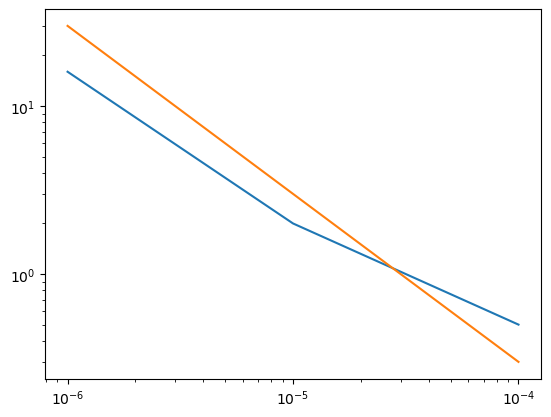

In [7]:
# scaling of delta t
xx = np.array([1e-6, 1e-5, 1e-4])
yy = np.array([16, 2, 0.5])

xxx = np.linspace(1e-6,1e-4,10)
yyy = 3e-5 * xxx ** (-1)

plt.loglog(xx,yy)
plt.loglog(xxx,yyy);

[0.06298576 0.08465432 0.1664675 ]


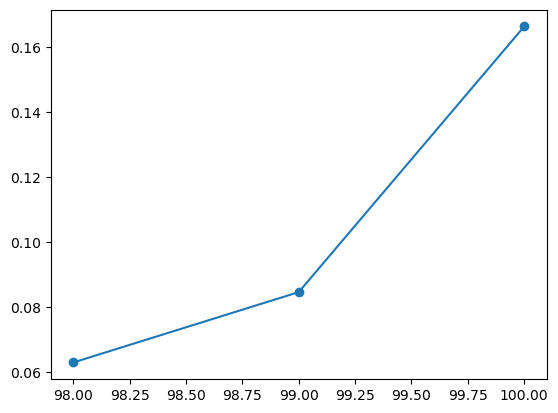

In [8]:
# errors at big time
Z_DNS_1en4_long = np.load("./discrete_misc_files/Z_DNS_1en4_long.npy")

MSE = np.zeros(3)

MSE[0] = np.sum((Z_DNS_1en4_long[:,:,9800]-Z_anal[:,:,0])**2) / N**2
MSE[1] = np.sum((Z_DNS_1en4_long[:,:,9900]-Z_anal[:,:,1])**2) / N**2
MSE[2] = np.sum((Z_DNS_1en4_long[:,:,10000]-Z_anal[:,:,2])**2) / N**2

    
print(MSE)
plt.plot([98,99,100], MSE, '-o');

there are 10001 total timesteps


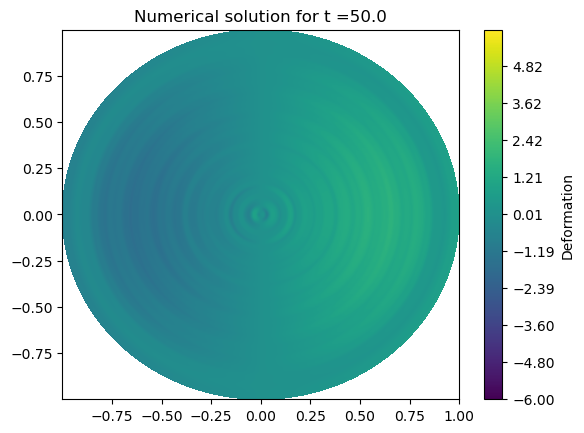

In [9]:
# test plot of numerical solution
shape = np.shape(Z_DNS_1en4_long)
print("there are " + str(shape[2]) + " total timesteps")

tstep = 5000
Z_numi = Z_DNS_1en4_long[:,:,tstep]

levels = np.linspace(-6,6,500)

plt.figure()

plot = plt.contourf(X, Y, Z_numi, levels=levels, cmap='viridis')

colorbar = plt.colorbar(plot)
colorbar.set_label('Deformation')
plt.title("Numerical solution for t ="+ str(tstep/100));

/tmp/ipykernel_275406/2840963357.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,2,1)


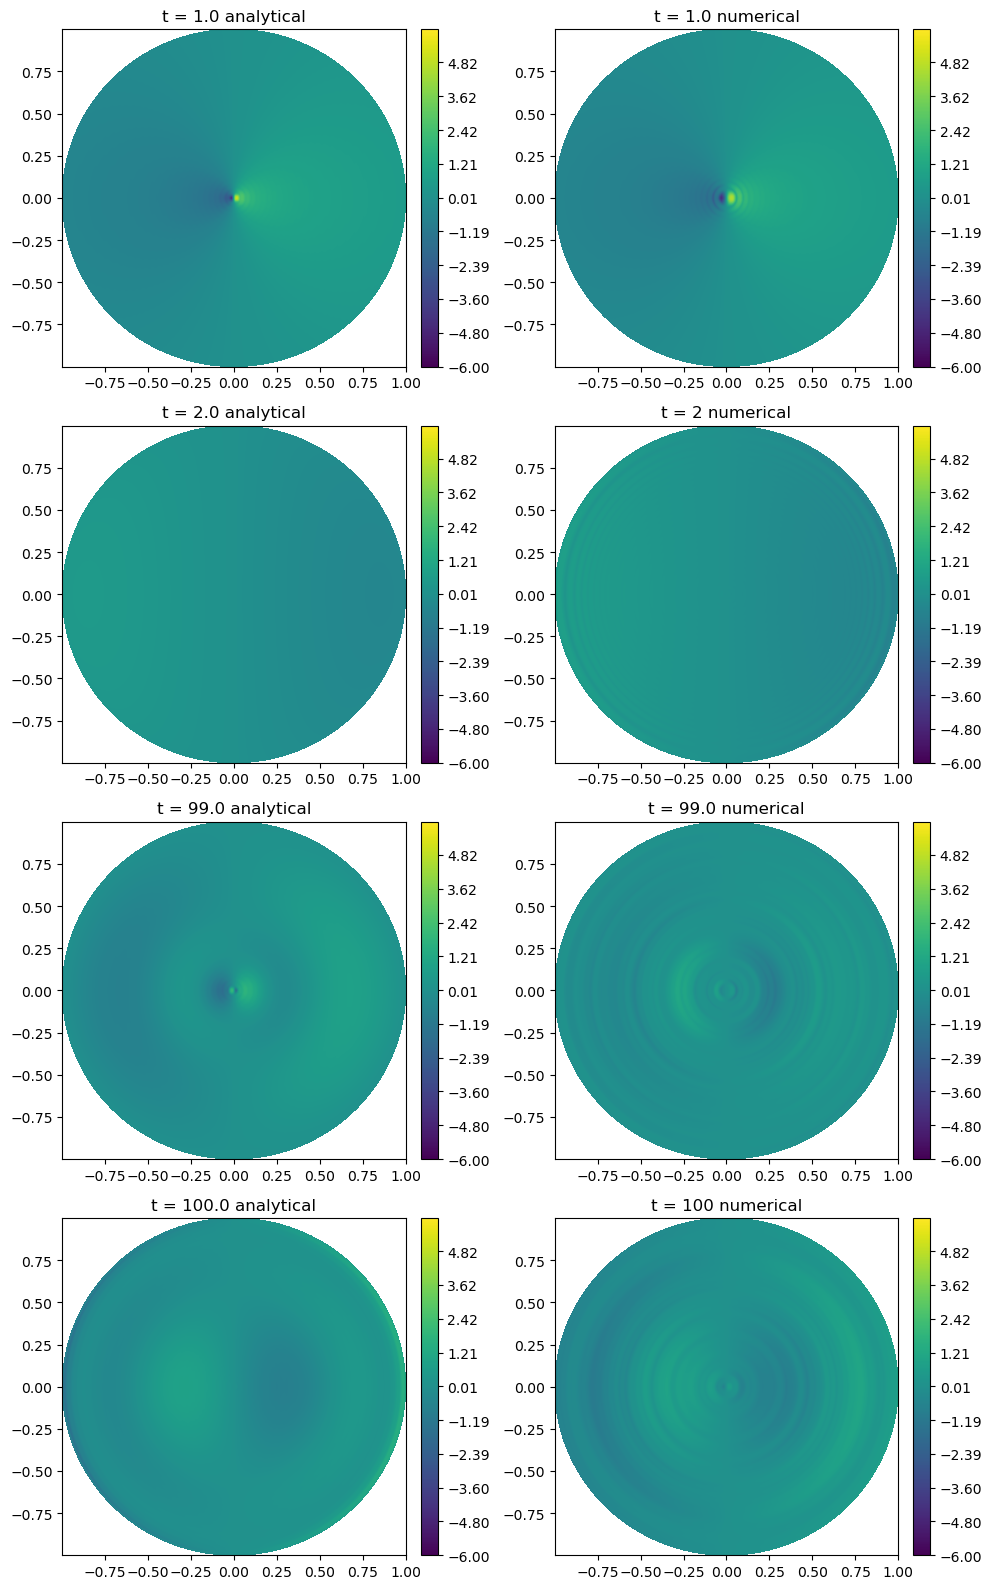

In [11]:
# ploting anal vs num for t = 1, 2, 99, 100

fig,ax = plt.subplots()
fig.set_figheight(16)
fig.set_figwidth(10)

levels = np.linspace(-6,6,500)



plt.subplot(4,2,1)
# plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
im = plt.contourf(X, Y, Z_anal[:,:,100], levels=levels, cmap='viridis')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("t = 1.0 analytical")

plt.subplot(4,2,2)
im = plt.contourf(X, Y, Z_DNS_1en4[:,:,100], levels=levels, cmap='viridis')
plt.title("t = 1.0 numerical")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(4,2,3)
im = plt.contourf(X, Y, Z_anal[:,:,200], levels=levels, cmap='viridis')
# plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("t = 2.0 analytical")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(4,2,4)
im = plt.contourf(X, Y, Z_DNS_1en4[:,:,200], levels=levels, cmap='viridis')
plt.title("t = 2 numerical")
plt.colorbar(im,fraction=0.046, pad=0.04)




plt.subplot(4,2,5)
# plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False) 
im = plt.contourf(X, Y, Z_anal_long[:,:,1], levels=levels, cmap='viridis')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("t = 99.0 analytical")

plt.subplot(4,2,6)
im = plt.contourf(X, Y, Z_DNS_1en4_long[:,:,9900], levels=levels, cmap='viridis')
plt.title("t = 99.0 numerical")
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(4,2,7)
im = plt.contourf(X, Y, Z_anal_long[:,:,2], levels=levels, cmap='viridis')
# plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("t = 100.0 analytical")
plt.colorbar(im,fraction=0.046, pad=0.04)


plt.subplot(4,2,8)
im = plt.contourf(X, Y, Z_DNS_1en4_long[:,:,10000], levels=levels, cmap='viridis')
plt.title("t = 100 numerical")
plt.colorbar(im,fraction=0.046, pad=0.04)



plt.tight_layout()
plt.savefig("./discrete_misc_files/big_comparison.png", dpi = 600)

/tmp/ipykernel_275406/2588691295.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


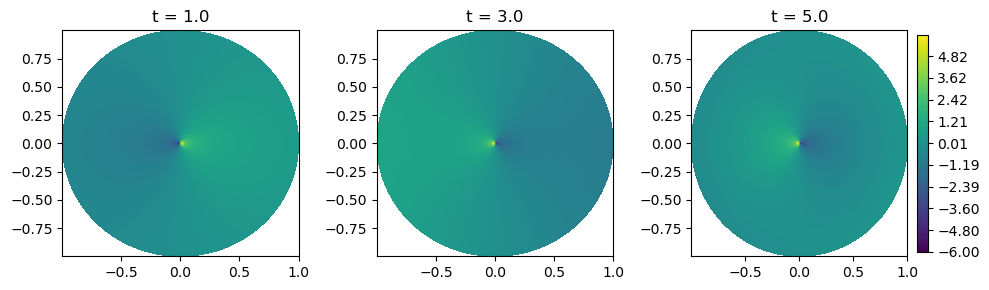

In [21]:
# ploting anal vs num for t = 1, 2, 99, 100

fig,ax = plt.subplots()
fig.set_figheight(3)
fig.set_figwidth(10)

levels = np.linspace(-6,6,500)



plt.subplot(1,3,1)
im = plt.contourf(X, Y, Z_anal[:,:,100], levels=levels, cmap='viridis')
plt.title("t = 1.0")

plt.subplot(1,3,2)
im = plt.contourf(X, Y, Z_anal[:,:,300], levels=levels, cmap='viridis')
plt.title("t = 3.0")

plt.subplot(1,3,3)
im = plt.contourf(X, Y, Z_anal[:,:,500], levels=levels, cmap='viridis')
# plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("t = 5.0")
plt.colorbar(im,fraction=0.046, pad=0.04)


plt.tight_layout()
plt.savefig("./discrete_misc_files/singularities.png", dpi = 600)